In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
PARTICLE_TYPE = 'pion'

In [3]:
MODEL_NAME = "FastFastRICH_Cramer_{}_5layers".format(PARTICLE_TYPE)

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
keras = tf.keras
ll = keras.layers
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import scipy
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

In [5]:
import rich_utils.utils_rich_mrartemev as utils_rich

In [7]:
data_train, data_val, scaler = utils_rich.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	../data/data_calibsample/pion_+_down_2016_.csv
	../data/data_calibsample/pion_-_down_2016_.csv
	../data/data_calibsample/pion2_+_up_2016_.csv
	../data/data_calibsample/pion_+_up_2016_.csv
	../data/data_calibsample/pion2_-_up_2016_.csv
	../data/data_calibsample/pion_-_up_2016_.csv
	../data/data_calibsample/pion2_+_down_2016_.csv
	../data/data_calibsample/pion2_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.8399324417114258
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


In [8]:
BATCH_SIZE = int(1e5)
LATENT_DIMENSIONS = 64
# tf.reset_default_graph()

In [9]:
data_train.shape

(2000000, 9)

In [10]:
data_train.head()

,RichDLLe,RichDLLk,RichDLLmu,RichDLLp,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight
0,-2.439535,-2.093872,-1.627121,-2.081804,-2.264097,-0.526635,-1.524430,-0.211704,1.234390
1,1.351525,-0.258730,1.302060,-0.965807,-0.792600,0.737145,0.510301,-0.716254,1.083780
2,-0.854941,0.011291,-1.372291,0.138639,0.134225,-0.981322,0.098671,1.173458,1.075660
3,1.128812,-0.208491,0.943825,-1.058936,-1.292043,1.280247,0.535150,-1.279242,0.581925
4,-0.960433,-1.045779,-0.192687,-1.032022,-1.135655,-0.058859,-0.041522,-0.293490,-0.894272


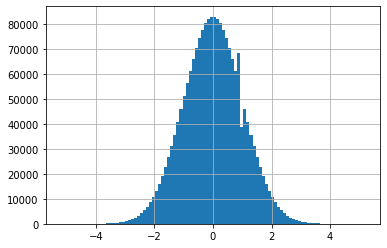

In [281]:
data_train.RichDLLe.hist(bins=100)

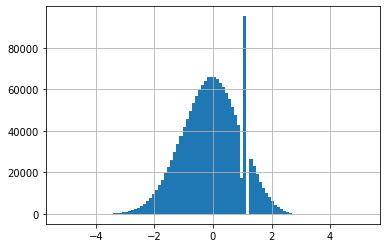

In [285]:
data_train.RichDLLp.hist(bins=100, weights=data_train.probe_sWeight)

In [68]:
def get_data_iterator(data, batch_size):
    return iter(tf.data.Dataset.from_tensor_slices(data).repeat().shuffle(batch_size + 1).batch(batch_size))

def data_generator(data, batch_size=BATCH_SIZE):
    it = get_data_iterator(data, batch_size)
    for x in it:
        yield x[:, :-1], x[:, -1]

In [69]:
train_full_ = data_train.values
train_x_1_ = data_train.values[:, utils_rich.y_count:]
train_x_2_ = data_train.values[:, utils_rich.y_count:]

train_full_gen = data_generator(train_full_)
train_x_1_gen = data_generator(train_x_1_)
train_x_2_gen = data_generator(train_x_2_)

In [155]:
N_VAL = int(3e5)
validation_np = data_val.sample(N_VAL).values

In [156]:
validation_full = validation_np[:, :-1]
validation_x = validation_full[:, utils_rich.y_count:]
validation_w = validation_np[:, -1]

In [111]:
LOGDIR = "tensorboard_logdir/"
MODEL_WEIGHTS_DIR = 'weights'

os.makedirs(LOGDIR, exist_ok=True)
os.makedirs(MODEL_WEIGHTS_DIR, exist_ok=True)
os.makedirs('preprocessors', exist_ok=True)


In [112]:
LOGDIR = "tensorboard_logdir/"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = 100
VALIDATION_INTERVAL = 10
MODEL_WEIGHTS_FILE = "{}/{}.ckpt".format(MODEL_WEIGHTS_DIR, MODEL_NAME)
# train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
# test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS
)

In [252]:
class CramerModel(keras.models.Model):
    def __init__(self, num_layers=5, cramer_dim=256, latent_dimensions=64, y_count=utils_rich.y_count):
        super(CramerModel, self).__init__()

        self.latent_dimensions = latent_dimensions
        self.crit = self.get_critic(num_layers, cramer_dim)
        self.gen = self.get_generator(num_layers, y_count)
    
    @staticmethod
    def get_dense(num_layers):
        return [ll.Dense(128, activation='relu') for _ in range(num_layers)]
    
    @classmethod
    def get_critic(cls, num_layers, cramer_dim):
        return cls.get_dense(num_layers) + [ll.Dense(cramer_dim)]

    @classmethod
    def get_generator(cls, num_layers, y_count):
        return cls.get_dense(num_layers) + [ll.Dense(y_count)]
    
    def generator(self, x):
        noise = tf.random.normal([x.shape[0], self.latent_dimensions])
        for l in self.gen:
            x = l(tf.concat([noise, x], axis=1))
        return x
    
    def critic(self, x):
        for l in self.crit:
            x = l(x)
        return x

    def cramer_critic(self, x, y):
        discriminated_x = self.critic(x)
        discriminated_y = self.critic(y)
        return tf.norm(discriminated_x - discriminated_y, axis=1) - tf.norm(discriminated_x, axis=1)
    
    def generator_loss(self, y1, w1, y2, w2, yt, wt):
        return tf.reduce_mean(
            self.cramer_critic(yt, y2) * wt * w2 -
            self.cramer_critic(y1, y2) * w1 * w2
        )
    
    def critic_loss(self, y1, w1, y2, w2, yt, wt, iteration=None):
        generator_loss = self.generator_loss(y1, w1, y2, w2, yt, wt)

        alpha = tf.random.uniform(shape=[yt.shape[0], 1], minval=0., maxval=1.)
        interpolates = alpha * yt + (1. - alpha) * y1
        with tf.GradientTape() as crit_tape:
            crit_tape.watch(interpolates)
            disc_interpolates = self.cramer_critic(interpolates, y2)
        gradients = crit_tape.gradient(disc_interpolates, [interpolates])[0]
        
        slopes = tf.norm(tf.reshape(gradients, [gradients.shape[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

        if iteration is None:
            lambda_tf = 10
        else:
            lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32) / 1e4)
        critic_loss = lambda_tf * gradient_penalty - generator_loss

        return critic_loss

In [274]:
class CramerModelOptimmizer:
    def __init__(self, model):
        self.optimizer = self.get_optimizer()
        self.model = model
    
    @staticmethod
    def get_optimizer():
        learning_rate = 1e-3
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            learning_rate,
            decay_steps=200,
            decay_rate=0.98,
        )
        return keras.optimizers.RMSprop(learning_rate=lr_schedule)
    
    def optimize(self, x_1, w_1, x_2, w_2, x_full, w_full, loss, weights):
        with tf.GradientTape() as critic_tape:
            y_1 = tf.concat([self.model.generator(x_1), x_1], axis=1)
            y_2 = tf.concat([self.model.generator(x_2), x_2], axis=1)
            loss_t = loss(y_1, w_1, y_2, w_2, x_full, w_full)
        grads = critic_tape.gradient(loss_t, weights)
        self.optimizer.apply_gradients(zip(grads, weights))
        return loss_t
    
    def optimize_critic(self, x_1, w_1, x_2, w_2, x_full, w_full):
        return self.optimize(x_1, w_1, x_2, w_2, x_full, w_full, self.model.critic_loss, model.crit.weights)
    
    def optimize_generator(self, x_1, w_1, x_2, w_2, x_full, w_full):
        return self.optimize(x_1, w_1, x_2, w_2, x_full, w_full, self.model.generator_loss, model.gen.weights)
    
#     def save(self):
#         self.optimizer.get_weights()
    
#     @classmethod
#     def load(cls):
#         self = cls()
#         weights = []
#         self.optimizer.set_weights(weights)

In [276]:
model = CramerModel(num_layers=1, cramer_dim=64, latent_dimensions=32)
optimizer = CramerModelOptimmizer(model)
generator_loss, critic_loss = [], []

In [277]:
try:
    model.load_weights(MODEL_WEIGHTS_FILE)
except:
    print('Model was not loaded')

In [278]:
all_data_gen = zip(train_full_gen, train_x_1_gen, train_x_2_gen)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


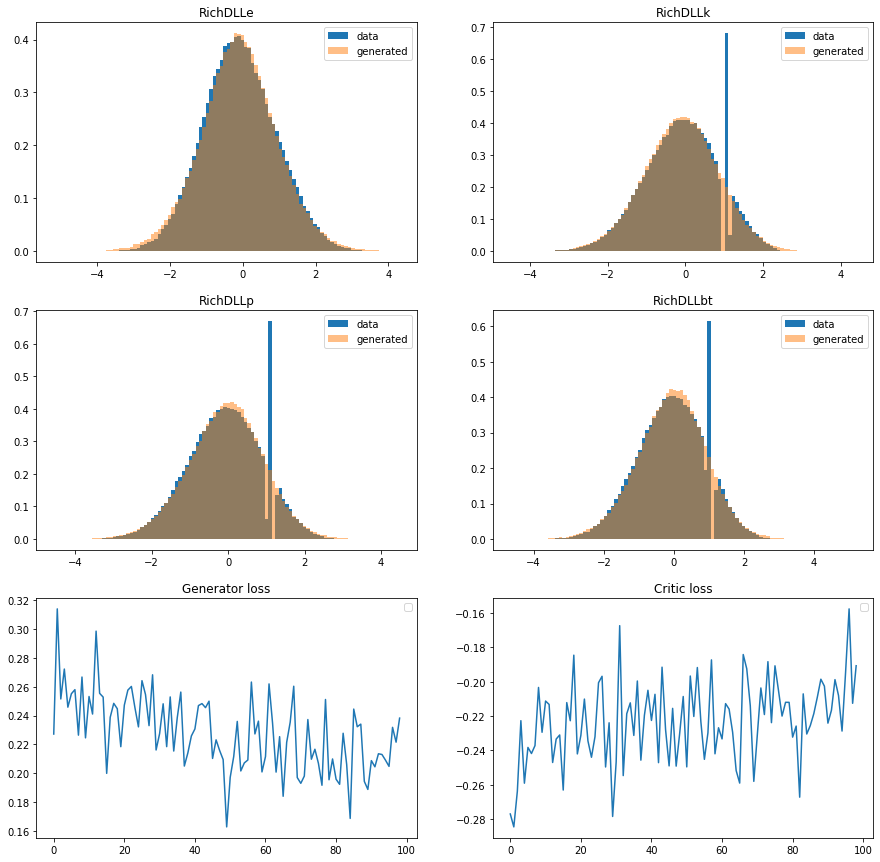

In [279]:
for i in range(len(generator_loss), TOTAL_ITERATIONS):
    for j in range(critic_policy(i)):
        (x_full, w_full), (x_1, w_1), (x_2, w_2) = next(all_data_gen)
        loss_t = optimizer.optimize_critic(x_1, w_1, x_2, w_2, x_full, w_full)
    critic_loss.append(loss_t)

    (x_full, w_full), (x_1, w_1), (x_2, w_2) = next(all_data_gen)
    loss_t = optimizer.optimize_generator(x_1, w_1, x_2, w_2, x_full, w_full)
    generator_loss.append(loss_t)
        
    if i % 2 == 0:
        model.save_weights(MODEL_WEIGHTS_FILE)
        clear_output(False)
        y_val = model.generator(validation_np[:, utils_rich.y_count:-1])
        
        fig, axes = plt.subplots(3, 2, figsize=(15, 15))
        for INDEX, ax in zip((0, 1, 3, 4), axes.flatten()):
            _, bins, _ = ax.hist(validation_np[:, INDEX], bins=100, label="data", normed=True,
                                 weights=validation_np[:,-1])
            ax.hist(y_val[:, INDEX], bins=bins, label="generated", alpha=0.5, normed=True,
                    weights=validation_np[:,-1])
            ax.legend()
            ax.set_title(utils_rich.dll_columns[INDEX])
        axes[2, 0].plot(list(range(len(generator_loss))), generator_loss)
        axes[2, 0].legend()
        axes[2, 0].set_title('Generator loss')
        axes[2, 1].plot(list(range(len(critic_loss))), critic_loss)
        axes[2, 1].legend()
        axes[2, 1].set_title('Critic loss')
        plt.show()